# 信用情報の学習

参考サイト：<br>
HOME CREDIT DEFAULT RISK — An End to End ML Case Study — PART 1: Introduction and EDA<br>
https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a<br>
上のgithub:https://github.com/rishabhrao1997/Home-Credit-Default-Risk/blob/main/EDA%20-%20Home%20Credit%20Default.ipynb<br>

【問題1】コンペティション内容の確認

1.何を学習し、何を予測するのか<br>
顧客の返済可・不可を予測する<br>
<br>
2.どのようなファイルを作りKaggleに提出するか<br>
testデータをモデルに与えて、顧客が返済不能に陥る確率をcsvデータにして提出<br>
<br>
3.提出されたものはどういった指標値で評価されるのか<br>
ROC曲線のAUCという指標。ROC曲線の下側の面積が大きければ大きいほどモデルの可用性が高い<br>


以下【問題2】学習と検証、【問題3】テストデータに対する推定

In [1]:
# 必要なデータ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from datetime import datetime 


%matplotlib inline
# import sys
# sys.path
DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/python/week3/Home_credit_Default_Risk/'


train = pd.read_csv(DIR_PATH+'application_train.csv')
test = pd.read_csv(DIR_PATH+'application_test.csv')
test_id = test['SK_ID_CURR']
pd.set_option('display.max_columns', train.shape[1])
pd.set_option('display.max_rows', 100)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [2]:
# 目的変数と説明変数を分類・ID情報の削除
train_y = train['TARGET']
train = train.drop('TARGET', axis=1)
train = train.drop('SK_ID_CURR', axis=1)
test = test.drop('SK_ID_CURR', axis=1)

In [3]:
# train, testデータのカテゴリーデータを数値データにone-hot-encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [4]:
train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,...,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1

In [5]:
test

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,...,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,2.0,2,2,14,0,0,0,0,0,0,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
# エンコーディング後のカラムに差が発生しているのでその対応
train_col = list(train.columns)
test_col = list(test.columns)

In [7]:

no_feats = []
for i in range(len(train_col)):
    if train_col[i] not in test_col:
        no_feats.append(train_col[i])

In [8]:
no_feats

['CODE_GENDER_XNA',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_FAMILY_STATUS_Unknown']

In [9]:
# 直前で求めたtestデータに存在しないカラムをtrainデータから削除
train = train.drop(no_feats, axis=1)

In [10]:
# LightGBMを使う際にtrain, testにjson型のデータが入っている為、それを解決する為の処理
train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train.columns]
test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test.columns]

In [11]:
# とりあえずsubmit　以下trainデータでモデル学習

# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.2)


    #データ読み込み
train_data=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19917, number of negative: 226091
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9264
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080961 -> initscore=-2.429364
[LightGBM] [Info] Start training from score -2.429364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

datetime.timedelta(seconds=15, microseconds=855918)

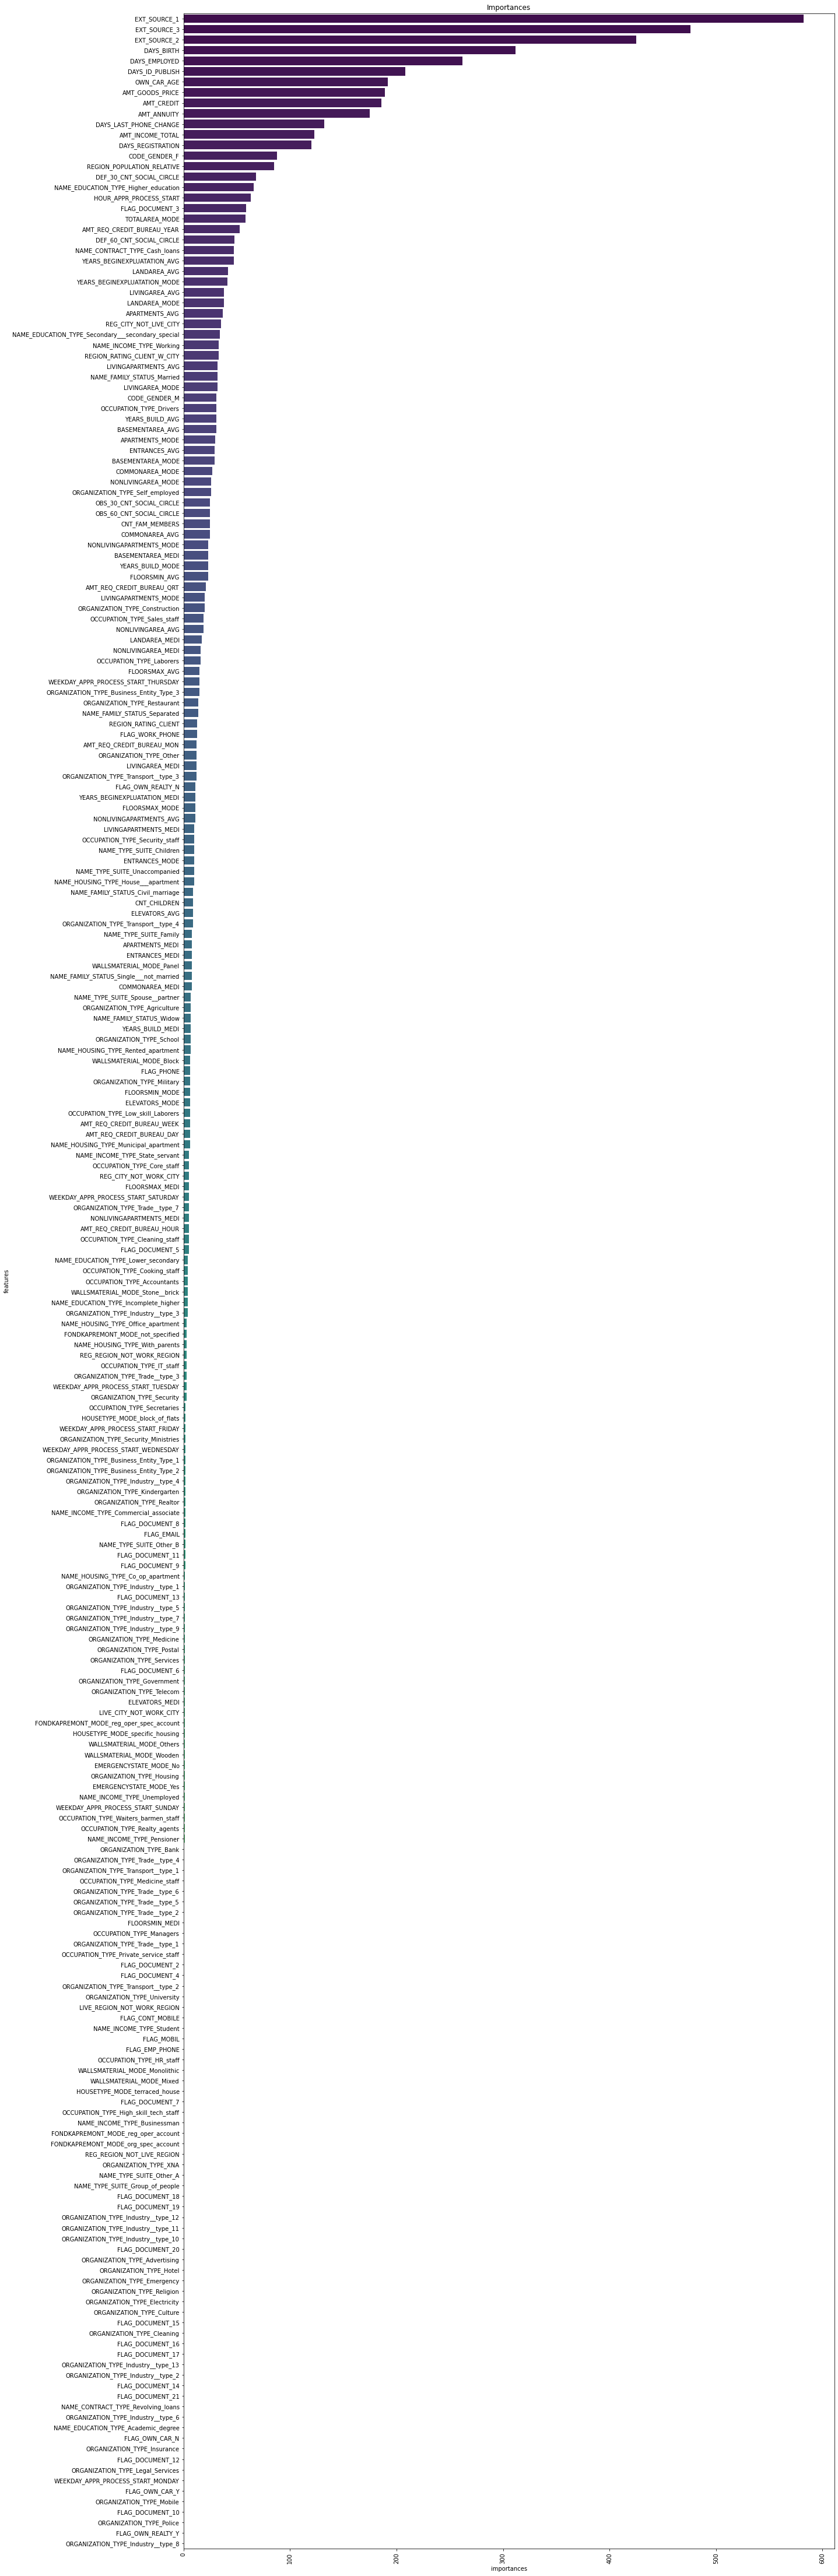

In [12]:
# 学習したモデルの各特徴量毎の重要度出力
train_feat = list(train.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,80))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

In [13]:
result

,importances,features
27,582,EXT_SOURCE_1
29,476,EXT_SOURCE_3
28,425,EXT_SOURCE_2
6,312,DAYS_BIRTH
7,262,DAYS_EMPLOYED
...,...,...
199,0,ORGANIZATION_TYPE_Mobile
86,0,FLAG_DOCUMENT_10
201,0,ORGANIZATION_TYPE_Police
111,0,FLAG_OWN_REALTY_Y


In [14]:
# 低重要度を削除
no_feats = result.loc[result['importances'] < 50, 'features']
len(no_feats)

220

In [15]:
test_ver2 = test.drop(columns=no_feats, axis=1)
train_ver2 = train.drop(columns=no_feats, axis=1)
train_ver2

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher_education
0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,10,0.083037,0.262949,0.139376,0.0149,2.0,-1134.0,1,1.0,0,0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,11,0.311267,0.622246,NaN,0.0714,0.0,-828.0,1,0.0,1,1
2,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,9,NaN,0.555912,0.729567,NaN,0.0,-815.0,0,0.0,0,0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,17,NaN,0.650442,NaN,NaN,0.0,-617.0,1,NaN,1,0
4,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,11,NaN,0.322738,NaN,NaN,0.0,-1106.0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,NaN,15,0.145570,0.681632,NaN,0.2898,0.0,-273.0,0,NaN,0,0
307507,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,NaN,8,NaN,0.115992,NaN,0.0214,0.0,0.0,1,NaN,1,0
307508,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,NaN,9,0.744026,0.535722,0.218859,0.7970,0.0,-1909.0,1,1.0,1,1
307509,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,NaN,9,NaN,0.514163,0.661024,0.0086,0.0,-322.0,1,0.0,1,0


In [16]:
# 重要度が高いカラムの欠損値
train_ver2.isnull().sum()

AMT_INCOME_TOTAL                             0
AMT_CREDIT                                   0
AMT_ANNUITY                                 12
AMT_GOODS_PRICE                            278
REGION_POPULATION_RELATIVE                   0
DAYS_BIRTH                                   0
DAYS_EMPLOYED                                0
DAYS_REGISTRATION                            0
DAYS_ID_PUBLISH                              0
OWN_CAR_AGE                             202929
HOUR_APPR_PROCESS_START                      0
EXT_SOURCE_1                            173378
EXT_SOURCE_2                               660
EXT_SOURCE_3                             60965
TOTALAREA_MODE                          148431
DEF_30_CNT_SOCIAL_CIRCLE                  1021
DAYS_LAST_PHONE_CHANGE                       1
FLAG_DOCUMENT_3                              0
AMT_REQ_CREDIT_BUREAU_YEAR               41519
CODE_GENDER_F                                0
NAME_EDUCATION_TYPE_Higher_education         0
dtype: int64

In [17]:
# データ分割
numerical_feats = train_ver2.dtypes[train_ver2.dtypes != 'object'].index
categorical_feats = train_ver2.dtypes[train_ver2.dtypes == 'object'].index

print(numerical_feats, len(numerical_feats))
print(categorical_feats, len(categorical_feats))

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'TOTALAREA_MODE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_F',
       'NAME_EDUCATION_TYPE_Higher_education'],
      dtype='object') 21
Index([], dtype='object') 0


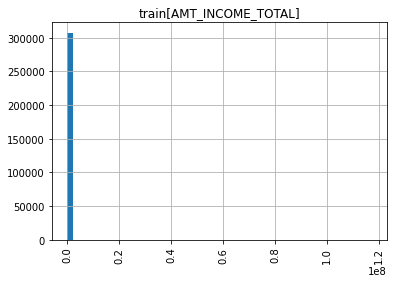

##################################################


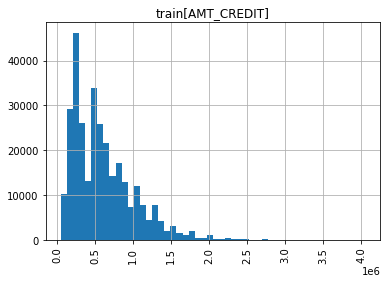

##################################################


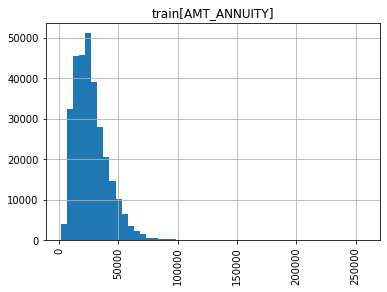

##################################################


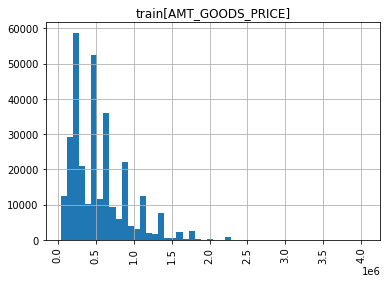

##################################################


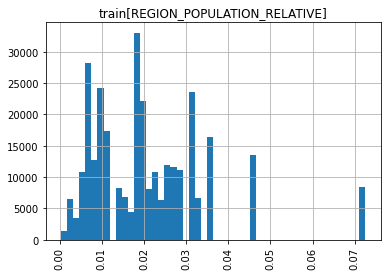

##################################################


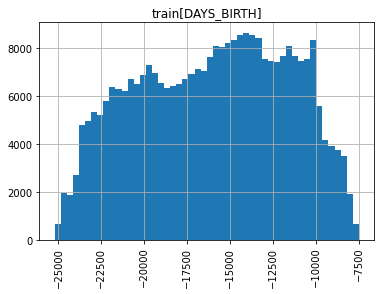

##################################################


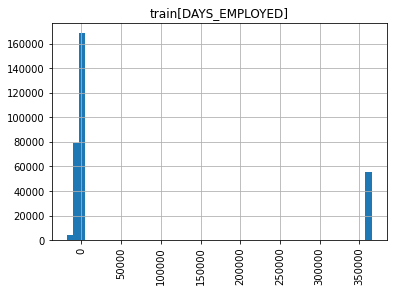

##################################################


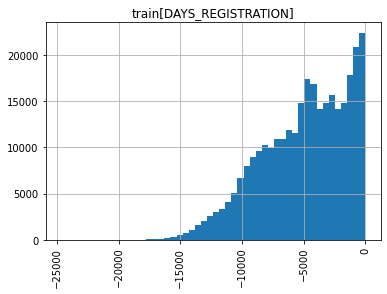

##################################################


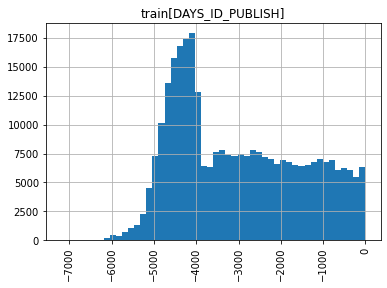

##################################################


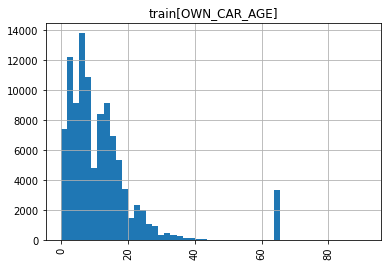

##################################################


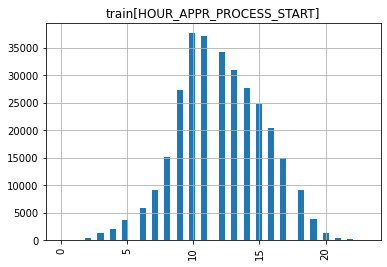

##################################################


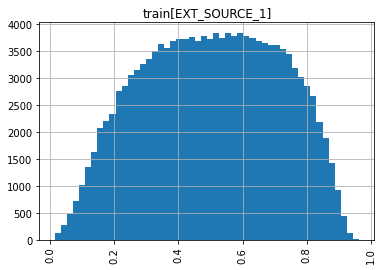

##################################################


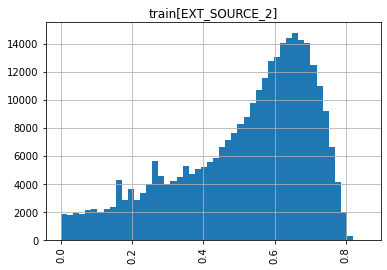

##################################################


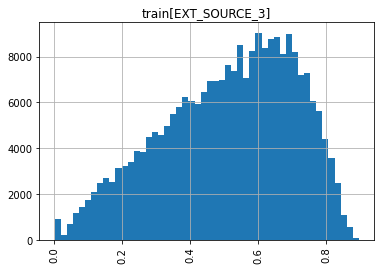

##################################################


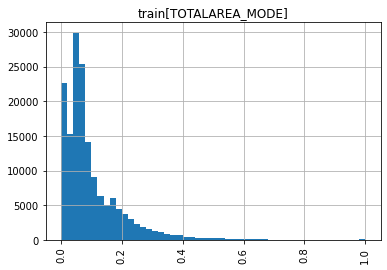

##################################################


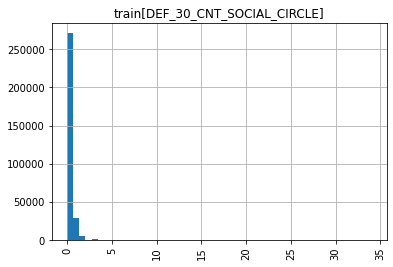

##################################################


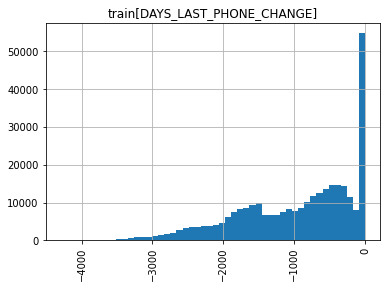

##################################################


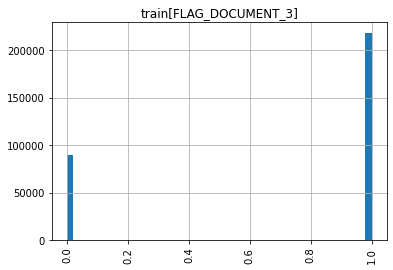

##################################################


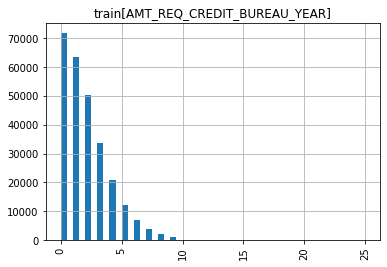

##################################################


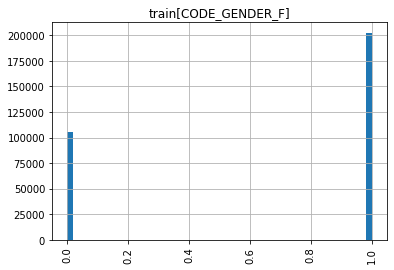

##################################################


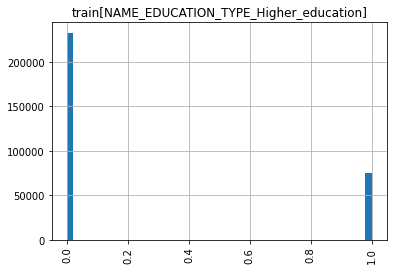

##################################################


In [18]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

考察：元カテゴリーデータも一部食い込んできている。ここをどう活かすか？<br>

In [19]:
# 高重要度データだけで再度LightGBM
# 結果振るわず。重要度順にした後、一旦EDAから特徴エンジニアリングが必要
import lightgbm as lgbm
# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train_ver2, train_y, test_size=0.2)


    #データ読み込み
train_data2=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data2,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19875, number of negative: 226133
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2734
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080790 -> initscore=-2.431661
[LightGBM] [Info] Start training from score -2.431661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

datetime.timedelta(seconds=4, microseconds=497066)

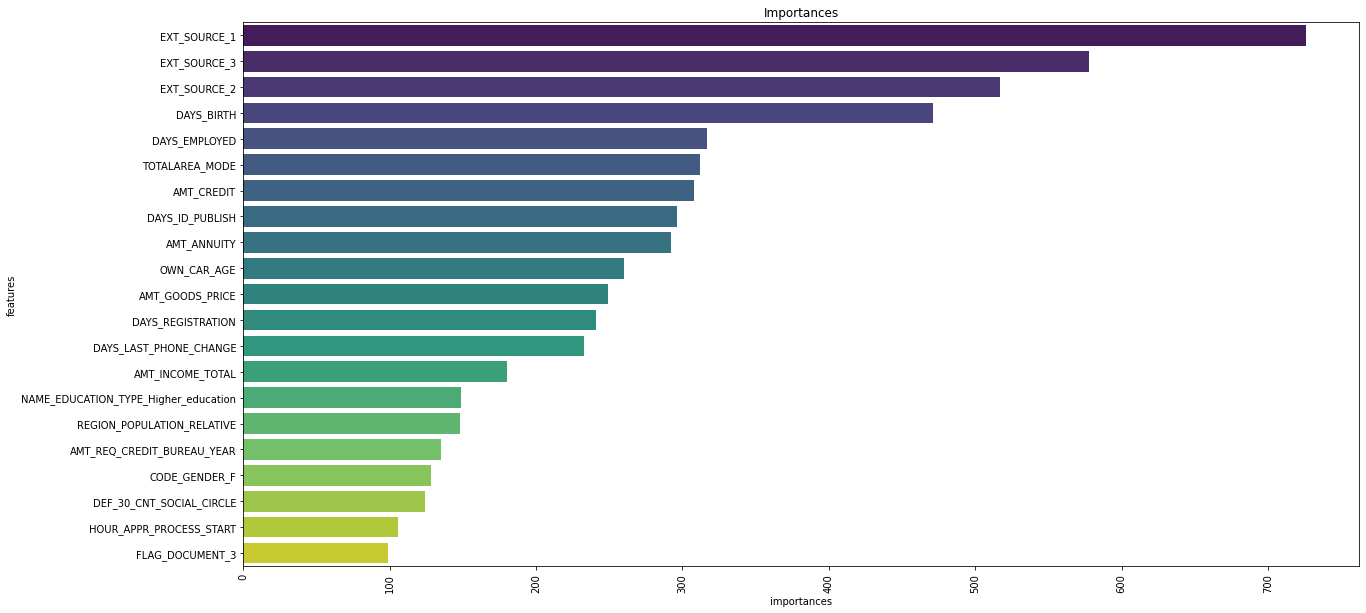

In [20]:
train_feat = list(train_ver2.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

### 以下提出の際に実行

In [87]:
ypred2=lgbm.predict(X_test)

In [88]:
auc_lgbm = roc_auc_score(y_test,ypred2)
auc_lgbm

0.7443771042124017

In [89]:
# テストデータで評価
test_pred = lgbm.predict(test_ver2)

In [90]:
test_pred.shape

(48744,)

In [91]:
# submit
submission = pd.read_csv(DIR_PATH+'sample_submission.csv')
submission['SK_ID_CURR'] = test_id
submission['TARGET'] = test_pred
submission.to_csv('submission.csv', index=False)

【問題4】特徴量エンジニアリング

1 どの特徴量を使うか<br>
問題2,3までの処理で、LightGBMで重要度の高い特徴量から考察して新規特徴量を作成していきたい<br>
2 どう前処理をするか<br>
欠損値処理、スコアリング等をしていく。<br>

やること<br>
1 DAYS_BIRTHを実年齢に<br>
2 DAYS_EMPLOYEDを年数に<br>
3 DAYS_REGISTRATIONを年数に<br>
4 DAYS_ID_PUBLISHを年数に<br>
5 OWN_CAR_AGEのNaNを0に<br>
6 EXT系列の欠損値対応<br>
7 

In [21]:
train_ver2

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher_education
0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,10,0.083037,0.262949,0.139376,0.0149,2.0,-1134.0,1,1.0,0,0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,11,0.311267,0.622246,NaN,0.0714,0.0,-828.0,1,0.0,1,1
2,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,9,NaN,0.555912,0.729567,NaN,0.0,-815.0,0,0.0,0,0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,17,NaN,0.650442,NaN,NaN,0.0,-617.0,1,NaN,1,0
4,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,11,NaN,0.322738,NaN,NaN,0.0,-1106.0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,-1982,NaN,15,0.145570,0.681632,NaN,0.2898,0.0,-273.0,0,NaN,0,0
307507,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,-4090,NaN,8,NaN,0.115992,NaN,0.0214,0.0,0.0,1,NaN,1,0
307508,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,-5150,NaN,9,0.744026,0.535722,0.218859,0.7970,0.0,-1909.0,1,1.0,1,1
307509,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,-931,NaN,9,NaN,0.514163,0.661024,0.0086,0.0,-322.0,1,0.0,1,0


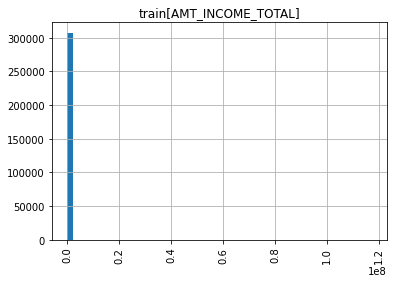

##################################################


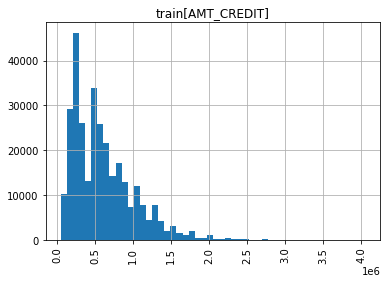

##################################################


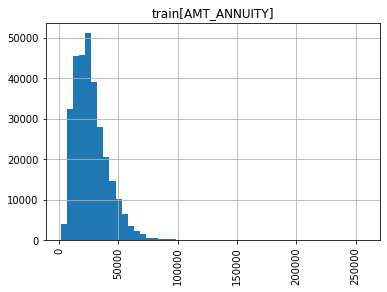

##################################################


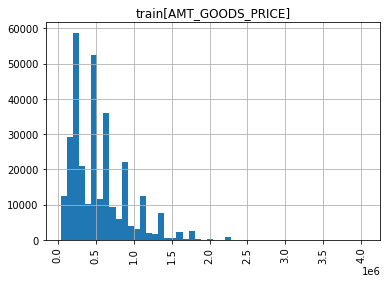

##################################################


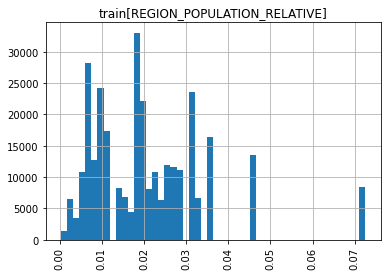

##################################################


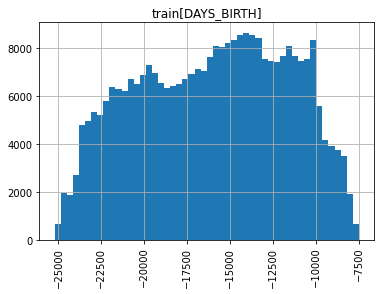

##################################################


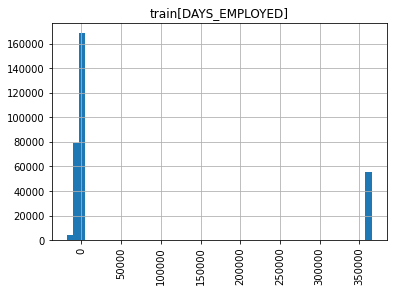

##################################################


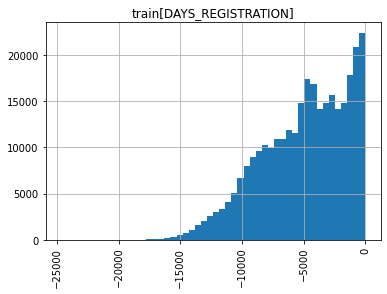

##################################################


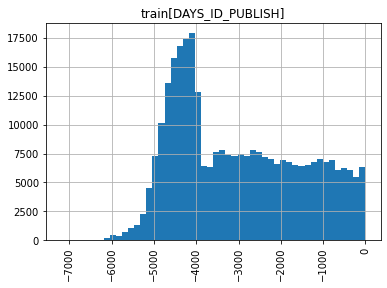

##################################################


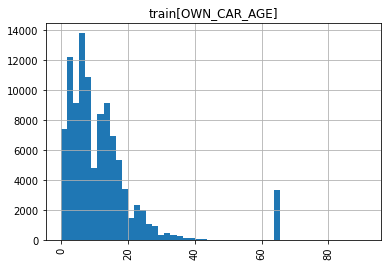

##################################################


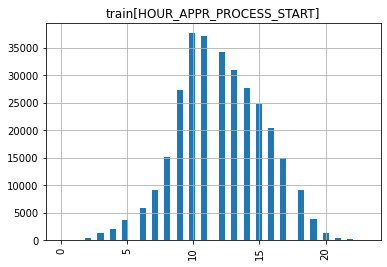

##################################################


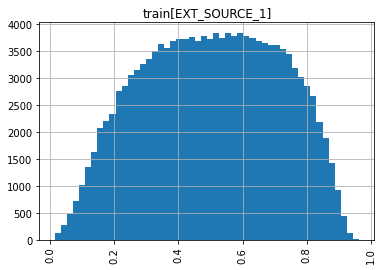

##################################################


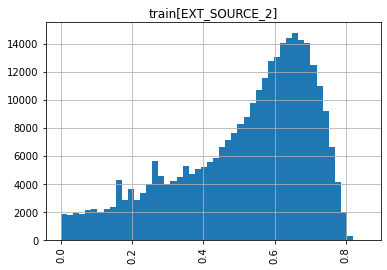

##################################################


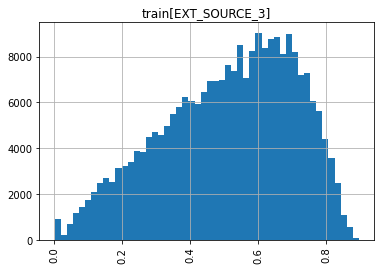

##################################################


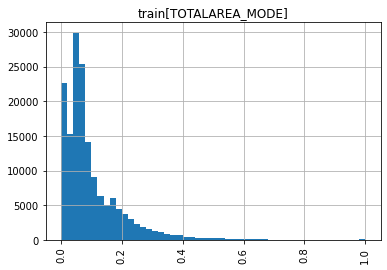

##################################################


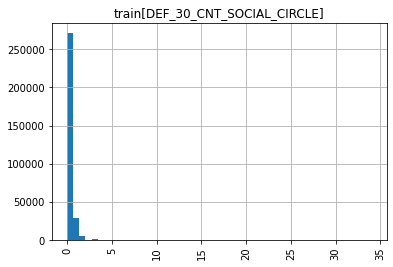

##################################################


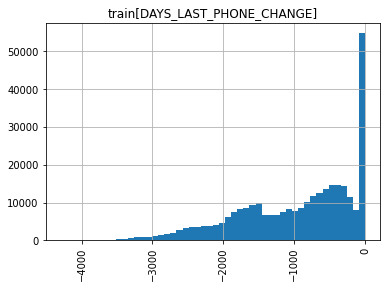

##################################################


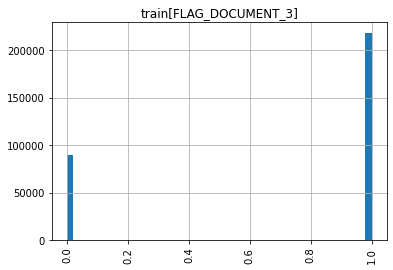

##################################################


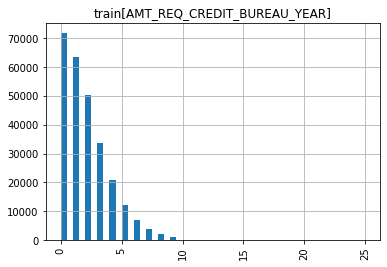

##################################################


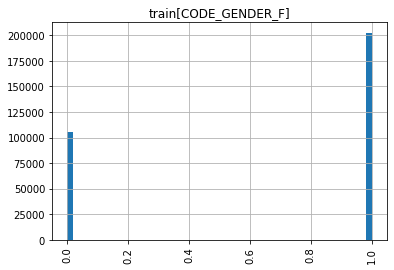

##################################################


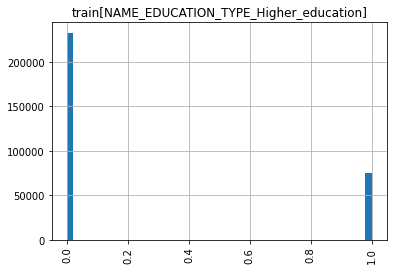

##################################################


In [22]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

In [23]:
train_ver2['DAYS_BIRTH'] = abs(train_ver2['DAYS_BIRTH'] / 365)
train_ver2['DAYS_LAST_PHONE_CHANGE'] = abs(train_ver2['DAYS_LAST_PHONE_CHANGE'] / 365)
train_ver2['DAYS_EMPLOYED'] = abs(train_ver2['DAYS_EMPLOYED'] / 365)
train_ver2['DAYS_REGISTRATION'] = abs(train_ver2['DAYS_REGISTRATION'] / 365)
train_ver2['DAYS_ID_PUBLISH'] = abs(train_ver2['DAYS_ID_PUBLISH'] / 365)
train_ver2.fillna({'OWN_CAR_AGE': 0, 'EXT_SOURCE_1':train_ver2['EXT_SOURCE_1'].mean(), \
                  'EXT_SOURCE_2':train_ver2['EXT_SOURCE_2'].mean(), \
                  'EXT_SOURCE_3':train_ver2['EXT_SOURCE_3'].mean()}, inplace=True)
train_ver2.fillna({'AMT_ANNUITY':train_ver2['AMT_ANNUITY'].mean(), \
                   'AMT_GOODS_PRICE':train_ver2['AMT_GOODS_PRICE'].mean()}, inplace=True)
train_ver2

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,NAME_EDUCATION_TYPE_Higher_education
0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,9.994521,5.808219,0.0,10,0.083037,0.262949,0.139376,0.0149,2.0,3.106849,1,1.0,0,0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,3.249315,0.797260,0.0,11,0.311267,0.622246,0.510853,0.0714,0.0,2.268493,1,0.0,1,1
2,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,11.671233,6.934247,26.0,9,0.502130,0.555912,0.729567,NaN,0.0,2.232877,0,0.0,0,0
3,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,26.939726,6.676712,0.0,17,0.502130,0.650442,0.510853,NaN,0.0,1.690411,1,NaN,1,0
4,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,11.810959,9.473973,0.0,11,0.502130,0.322738,0.510853,NaN,0.0,3.030137,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,157500.0,254700.0,27558.0,225000.0,0.032561,25.553425,0.646575,23.167123,5.430137,0.0,15,0.145570,0.681632,0.510853,0.2898,0.0,0.747945,0,NaN,0,0
307507,72000.0,269550.0,12001.5,225000.0,0.025164,56.917808,1000.665753,12.021918,11.205479,0.0,8,0.502130,0.115992,0.510853,0.0214,0.0,0.000000,1,NaN,1,0
307508,153000.0,677664.0,29979.0,585000.0,0.005002,41.002740,21.701370,18.457534,14.109589,0.0,9,0.744026,0.535722,0.218859,0.7970,0.0,5.230137,1,1.0,1,1
307509,171000.0,370107.0,20205.0,319500.0,0.005313,32.769863,13.112329,7.019178,2.550685,0.0,9,0.502130,0.514163,0.661024,0.0086,0.0,0.882192,1,0.0,1,0


In [24]:
train_ver2.isnull().sum()

AMT_INCOME_TOTAL                             0
AMT_CREDIT                                   0
AMT_ANNUITY                                  0
AMT_GOODS_PRICE                              0
REGION_POPULATION_RELATIVE                   0
DAYS_BIRTH                                   0
DAYS_EMPLOYED                                0
DAYS_REGISTRATION                            0
DAYS_ID_PUBLISH                              0
OWN_CAR_AGE                                  0
HOUR_APPR_PROCESS_START                      0
EXT_SOURCE_1                                 0
EXT_SOURCE_2                                 0
EXT_SOURCE_3                                 0
TOTALAREA_MODE                          148431
DEF_30_CNT_SOCIAL_CIRCLE                  1021
DAYS_LAST_PHONE_CHANGE                       1
FLAG_DOCUMENT_3                              0
AMT_REQ_CREDIT_BUREAU_YEAR               41519
CODE_GENDER_F                                0
NAME_EDUCATION_TYPE_Higher_education         0
dtype: int64

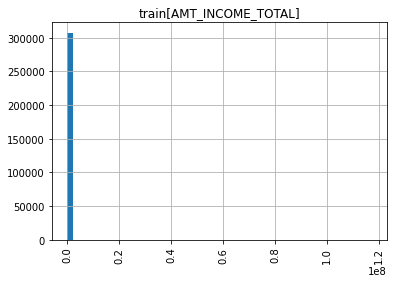

##################################################


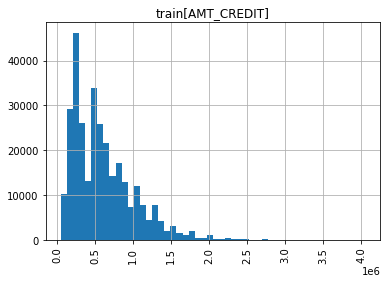

##################################################


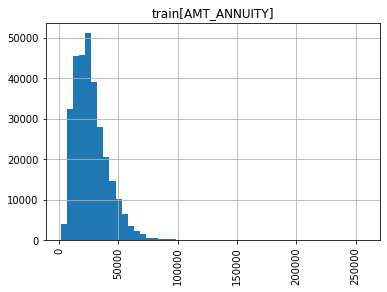

##################################################


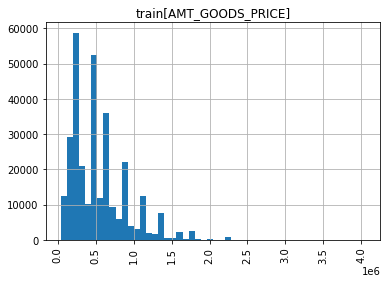

##################################################


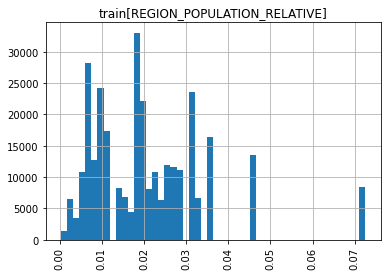

##################################################


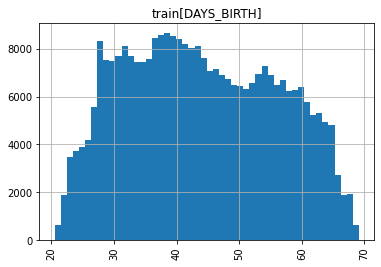

##################################################


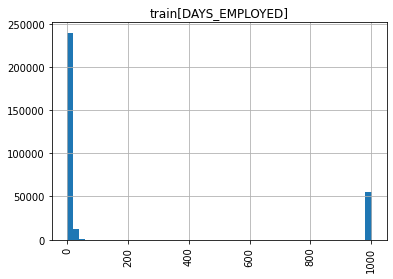

##################################################


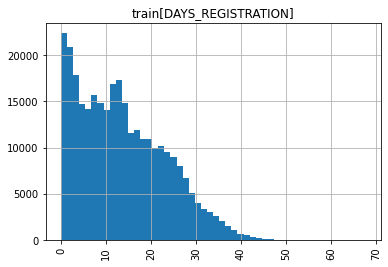

##################################################


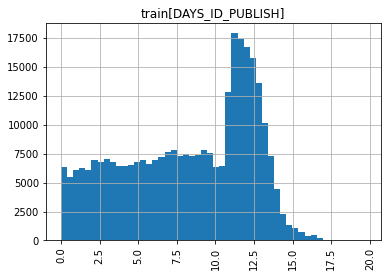

##################################################


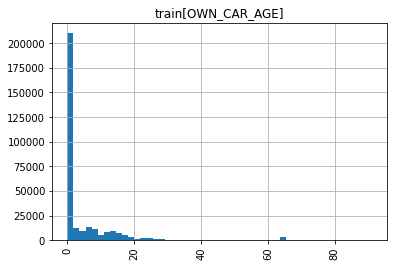

##################################################


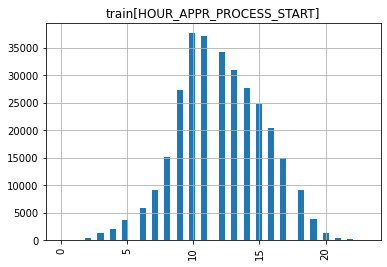

##################################################


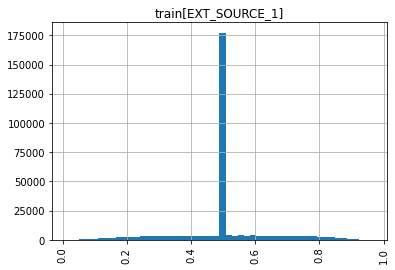

##################################################


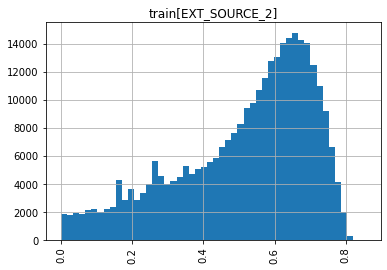

##################################################


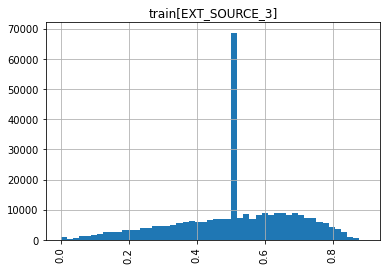

##################################################


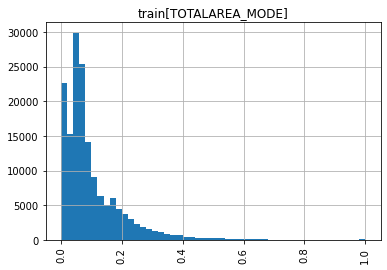

##################################################


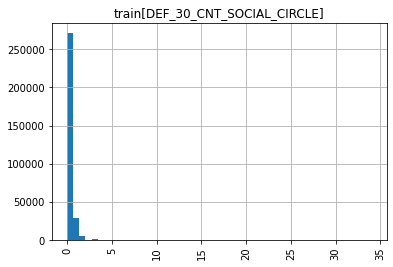

##################################################


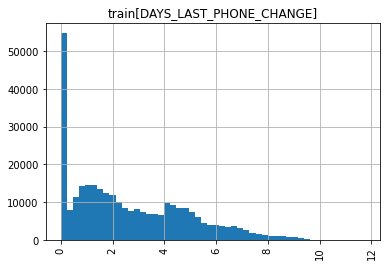

##################################################


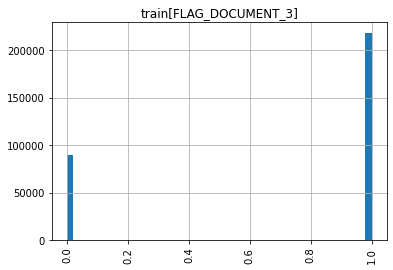

##################################################


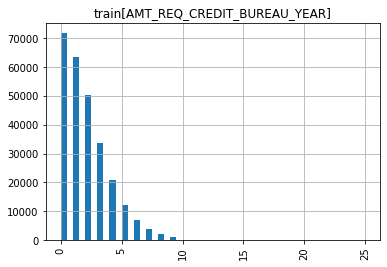

##################################################


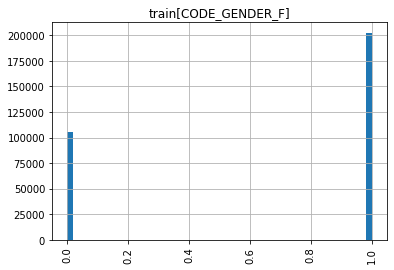

##################################################


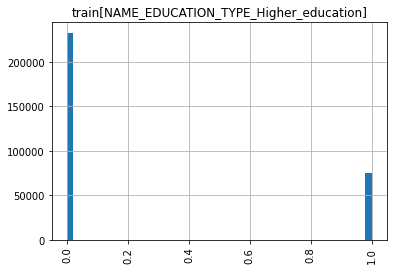

##################################################


In [25]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train_ver2[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

In [26]:
train_ver2.fillna({'AMT_REQ_CREDIT_BUREAU_YEAR':0}, inplace=True)

In [27]:
train_ver2.fillna({'TOTALAREA_MODE':train_ver2['TOTALAREA_MODE'].mean()}, inplace=True)

In [28]:
train_ver2.fillna({'DEF_30_CNT_SOCIAL_CIRCLE':0}, inplace=True)

In [29]:
# ここで再度LGB 重要特徴量の欠損値埋め後
import lightgbm as lgbm
# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train_ver2, train_y, test_size=0.2)


    #データ読み込み
train_data2=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data2,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19871, number of negative: 226137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2762
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080774 -> initscore=-2.431880
[LightGBM] [Info] Start training from score -2.431880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

datetime.timedelta(seconds=4, microseconds=244045)

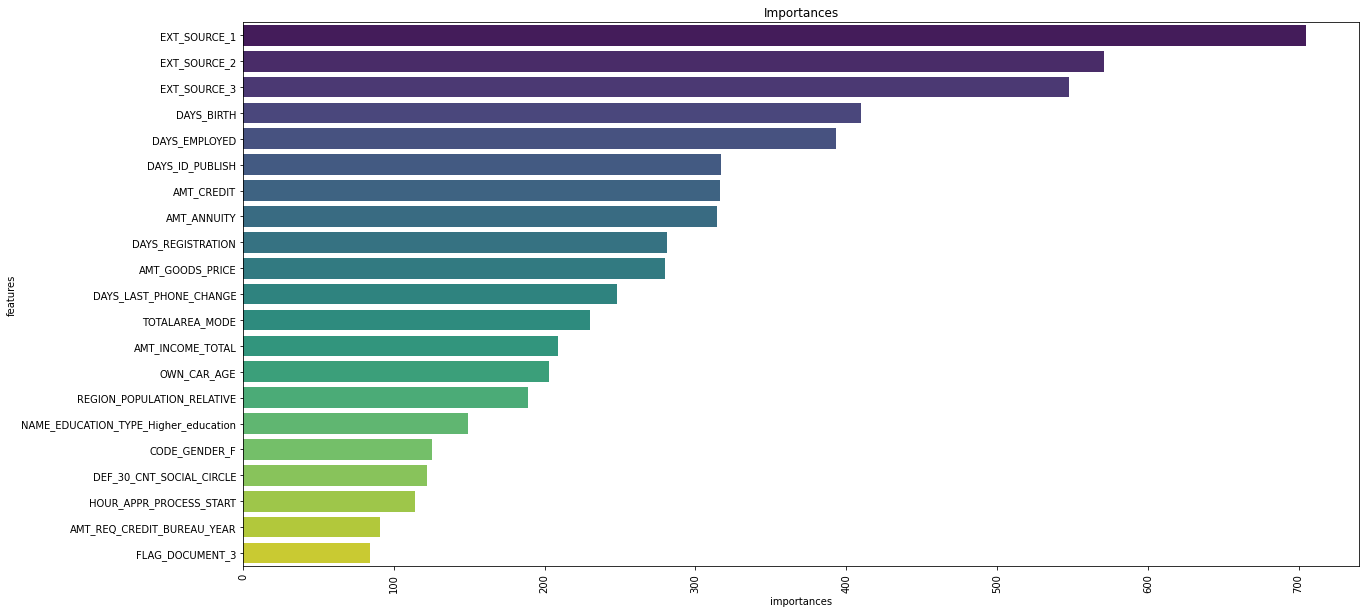

In [30]:
train_feat = list(train_ver2.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

In [32]:
test_ver2.isnull().sum()

AMT_INCOME_TOTAL                            0
AMT_CREDIT                                  0
AMT_ANNUITY                                24
AMT_GOODS_PRICE                             0
REGION_POPULATION_RELATIVE                  0
DAYS_BIRTH                                  0
DAYS_EMPLOYED                               0
DAYS_REGISTRATION                           0
DAYS_ID_PUBLISH                             0
OWN_CAR_AGE                             32312
HOUR_APPR_PROCESS_START                     0
EXT_SOURCE_1                            20532
EXT_SOURCE_2                                8
EXT_SOURCE_3                             8668
TOTALAREA_MODE                          22624
DEF_30_CNT_SOCIAL_CIRCLE                   29
DAYS_LAST_PHONE_CHANGE                      0
FLAG_DOCUMENT_3                             0
AMT_REQ_CREDIT_BUREAU_YEAR               6049
CODE_GENDER_F                               0
NAME_EDUCATION_TYPE_Higher_education        0
dtype: int64

In [33]:
test_ver2['DAYS_BIRTH'] = abs(test_ver2['DAYS_BIRTH'] / 365)
test_ver2['DAYS_LAST_PHONE_CHANGE'] = abs(test_ver2['DAYS_LAST_PHONE_CHANGE'] / 365)
test_ver2['DAYS_EMPLOYED'] = abs(test_ver2['DAYS_EMPLOYED'] / 365)
test_ver2['DAYS_REGISTRATION'] = abs(test_ver2['DAYS_REGISTRATION'] / 365)
test_ver2['DAYS_ID_PUBLISH'] = abs(test_ver2['DAYS_ID_PUBLISH'] / 365)
test_ver2.fillna({'OWN_CAR_AGE': 0, 'EXT_SOURCE_1':test_ver2['EXT_SOURCE_1'].mean(), \
                  'EXT_SOURCE_2':test_ver2['EXT_SOURCE_2'].mean(), \
                  'EXT_SOURCE_3':test_ver2['EXT_SOURCE_3'].mean()}, inplace=True)
test_ver2.fillna({'AMT_ANNUITY':test_ver2['AMT_ANNUITY'].mean(), \
                   'AMT_GOODS_PRICE':test_ver2['AMT_GOODS_PRICE'].mean()}, inplace=True)
test_ver2.fillna({'AMT_REQ_CREDIT_BUREAU_YEAR':0}, inplace=True)
test_ver2.fillna({'TOTALAREA_MODE':test_ver2['TOTALAREA_MODE'].mean()}, inplace=True)
test_ver2.fillna({'DEF_30_CNT_SOCIAL_CIRCLE':0}, inplace=True)

In [40]:
test_ver2.isnull().sum()

AMT_INCOME_TOTAL                        0
AMT_CREDIT                              0
AMT_ANNUITY                             0
AMT_GOODS_PRICE                         0
REGION_POPULATION_RELATIVE              0
DAYS_BIRTH                              0
DAYS_EMPLOYED                           0
DAYS_REGISTRATION                       0
DAYS_ID_PUBLISH                         0
OWN_CAR_AGE                             0
HOUR_APPR_PROCESS_START                 0
EXT_SOURCE_1                            0
EXT_SOURCE_2                            0
EXT_SOURCE_3                            0
TOTALAREA_MODE                          0
DEF_30_CNT_SOCIAL_CIRCLE                0
DAYS_LAST_PHONE_CHANGE                  0
FLAG_DOCUMENT_3                         0
AMT_REQ_CREDIT_BUREAU_YEAR              0
CODE_GENDER_F                           0
NAME_EDUCATION_TYPE_Higher_education    0
dtype: int64

重要特徴量の欠損値処理後再度精度確認<br>
auc:0.73269→0.73144<br>

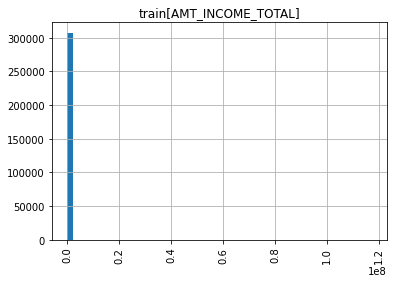

##################################################


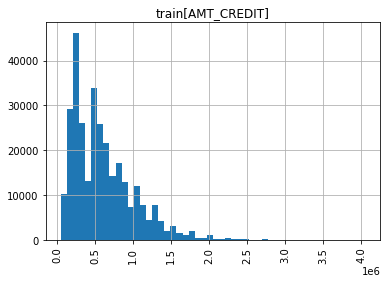

##################################################


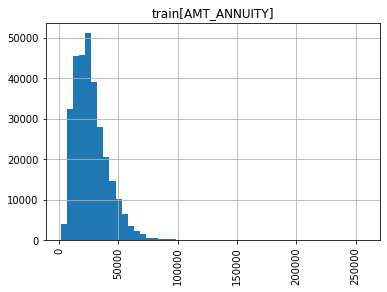

##################################################


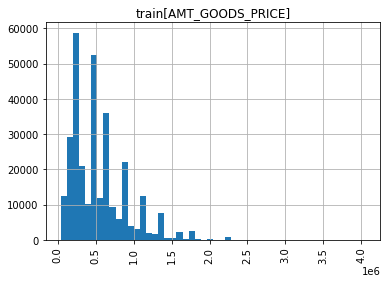

##################################################


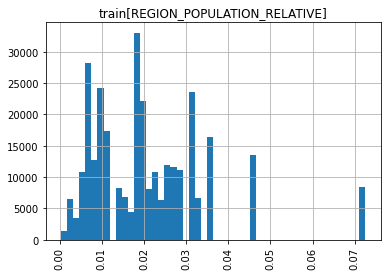

##################################################


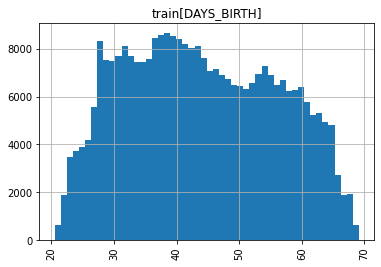

##################################################


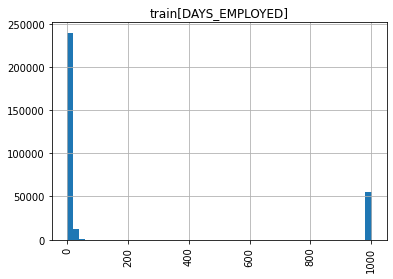

##################################################


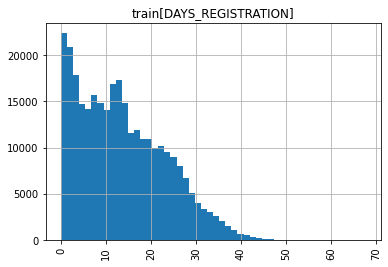

##################################################


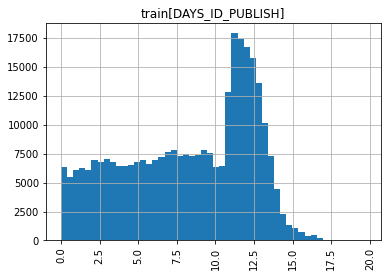

##################################################


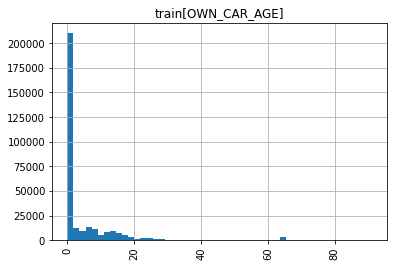

##################################################


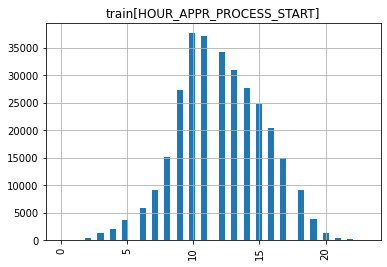

##################################################


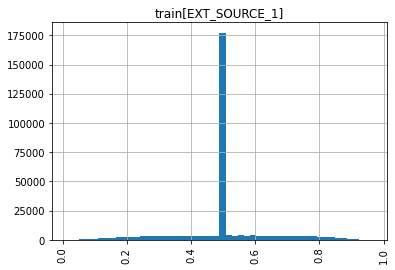

##################################################


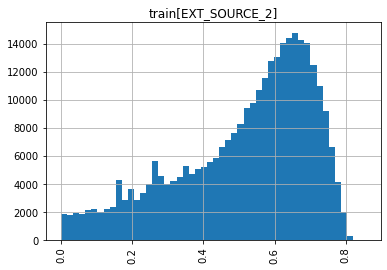

##################################################


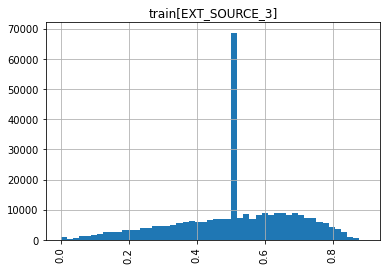

##################################################


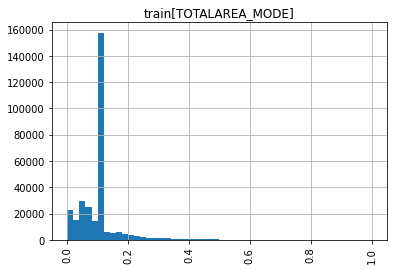

##################################################


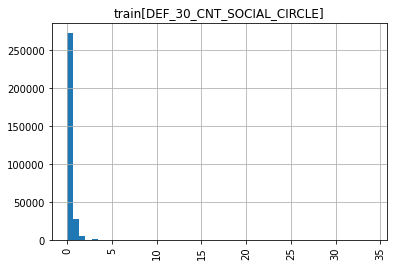

##################################################


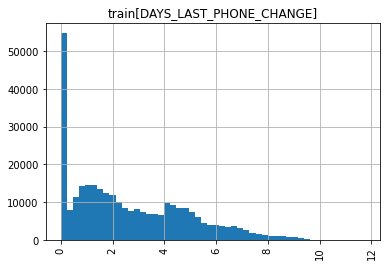

##################################################


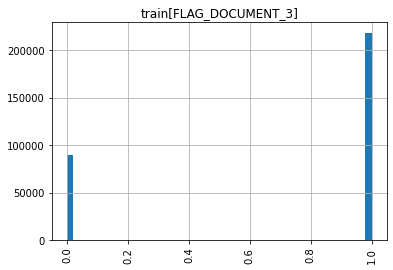

##################################################


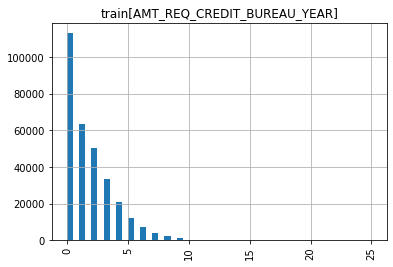

##################################################


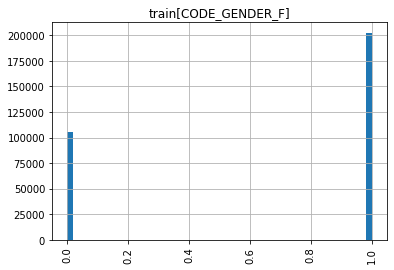

##################################################


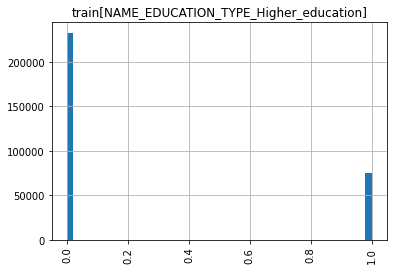

##################################################


In [41]:
# 数値データの分布
for col in numerical_feats:
    plt.title('train[{}]'.format(col))
    train_ver2[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

In [83]:
# これに入力するデータはtrain_ver2, test_ver2
def feature_engineer(df):
    # 収入に対する借入比率
    df['credit_ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    # DAYS_EMPLOEE補正
    for i in range(len(df)):
        if df.loc[i, 'DAYS_EMPLOYED'] > 50:
            df.loc[i, 'DAYS_EMPLOYED'] = df.loc[i, 'DAYS_EMPLOYED'] / 100
            
    # よくわからんけどとりあえず対数とってみる
    log_feats = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'credit_ratio']
    df[log_feats] = df[log_feats].apply(np.log)
    df[df[log_feats] == float('-inf')] = 0
    
    # その他のAMTデータでも比率をとってみる
    df['AMT_ANNUITY_ratio'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['AMT_GOODS_PRICE_ratio'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    
    return df

In [43]:
train_ver3 = feature_engineer(train_ver2)
test_ver3 = feature_engineer(test_ver2)

In [49]:
# ここで再度LGB 収入に対する借入比率の追加、雇用日数の補正後
import lightgbm as lgbm
# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train_ver3, train_y, test_size=0.2)


    #データ読み込み
train_data2=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data2,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19877, number of negative: 226131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2965
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080798 -> initscore=-2.431551
[LightGBM] [Info] Start training from score -2.431551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

datetime.timedelta(seconds=3, microseconds=672528)

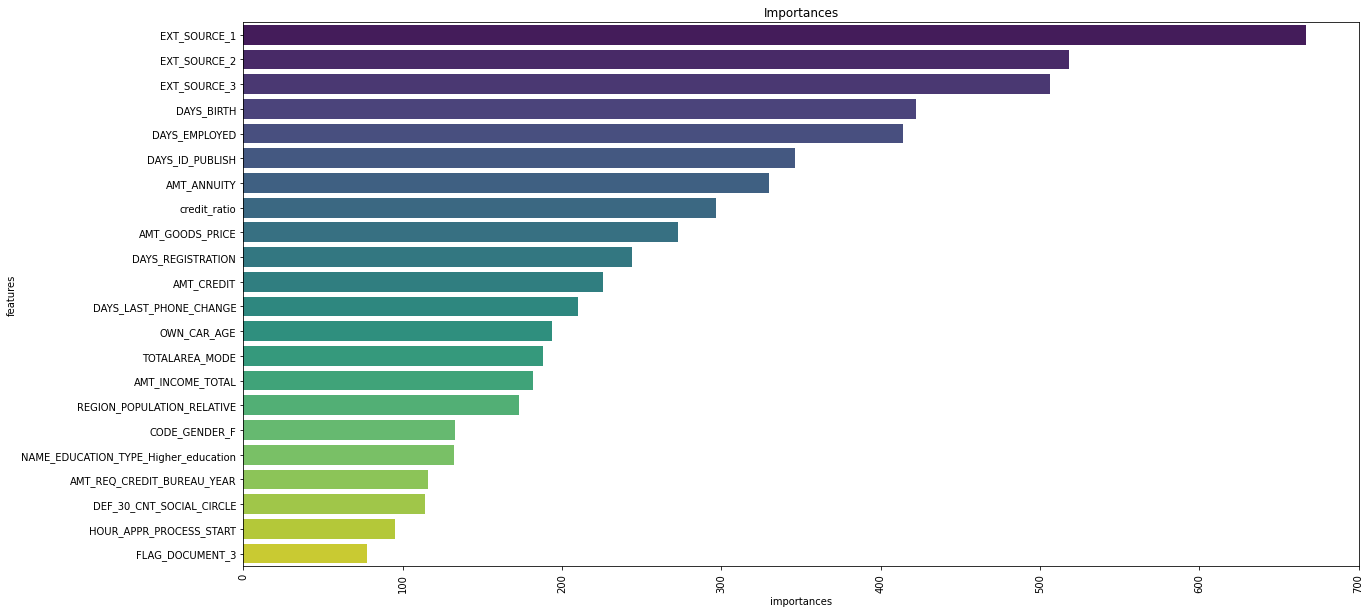

In [50]:
train_feat = list(train_ver3.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

auc:0.73144→0.72971<br>
追加した特徴量の寄与率は上がっているものの、スコアは下がっている<br>

In [72]:
# いくつかの変数で対数とったやつ
train_ver4 = feature_engineer(train_ver2)
test_ver4 = feature_engineer(test_ver2)

In [73]:
# ここで再度LGB いくつかの変数で対数をとったやつ
import lightgbm as lgbm
# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train_ver4, train_y, test_size=0.2)


    #データ読み込み
train_data2=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data2,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19820, number of negative: 226188
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080566 -> initscore=-2.434675
[LightGBM] [Info] Start training from score -2.434675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

datetime.timedelta(seconds=3, microseconds=488023)

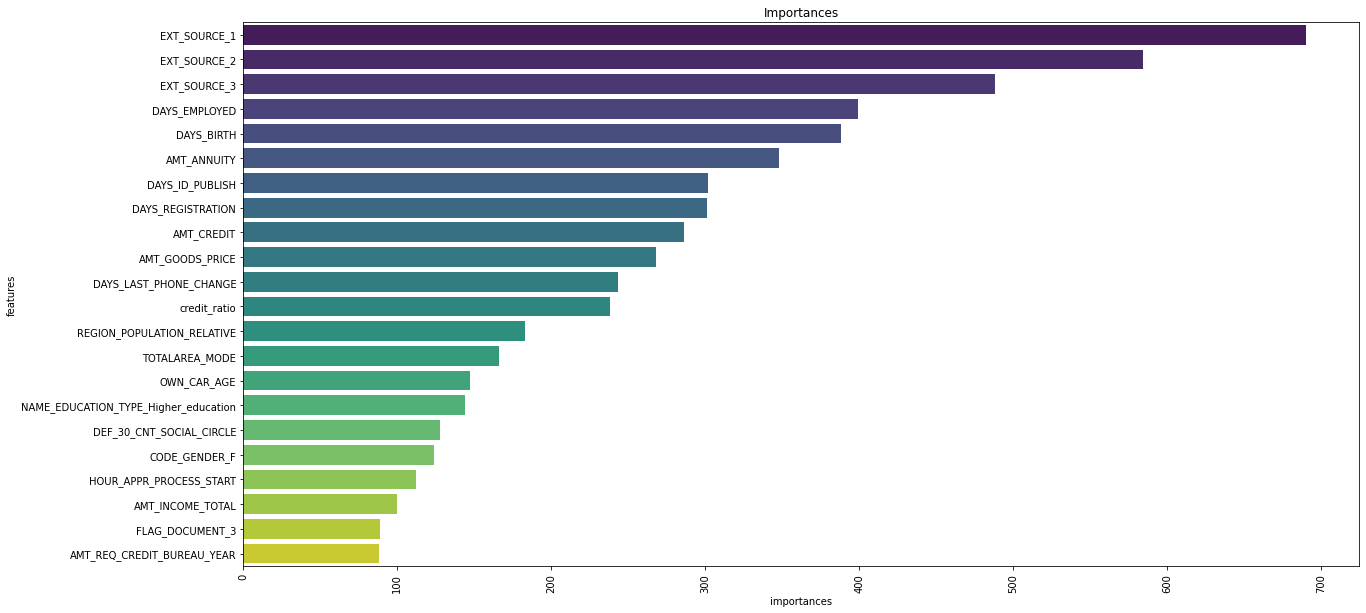

In [74]:
train_feat = list(train_ver3.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

In [75]:
train_ver4.min()

AMT_INCOME_TOTAL                        2.565000e+04
AMT_CREDIT                              2.371590e+00
AMT_ANNUITY                             1.999776e+00
AMT_GOODS_PRICE                         2.361708e+00
REGION_POPULATION_RELATIVE              2.900000e-04
DAYS_BIRTH                              2.051781e+01
DAYS_EMPLOYED                           0.000000e+00
DAYS_REGISTRATION                      -5.901266e+00
DAYS_ID_PUBLISH                         0.000000e+00
OWN_CAR_AGE                             0.000000e+00
HOUR_APPR_PROCESS_START                 0.000000e+00
EXT_SOURCE_1                            1.456813e-02
EXT_SOURCE_2                            8.173617e-08
EXT_SOURCE_3                            5.272652e-04
TOTALAREA_MODE                          0.000000e+00
DEF_30_CNT_SOCIAL_CIRCLE                0.000000e+00
DAYS_LAST_PHONE_CHANGE                  0.000000e+00
FLAG_DOCUMENT_3                         0.000000e+00
AMT_REQ_CREDIT_BUREAU_YEAR              0.0000

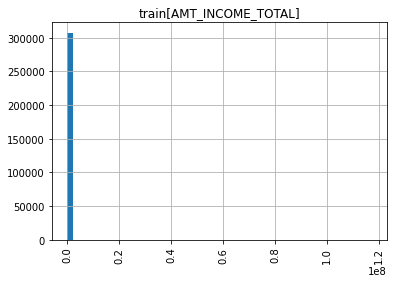

##################################################


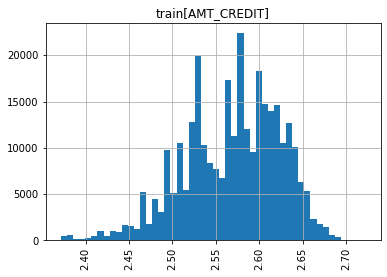

##################################################


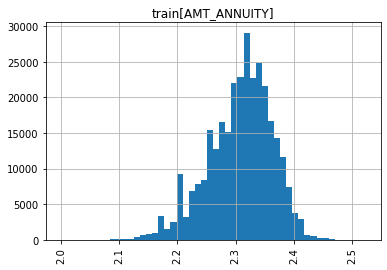

##################################################


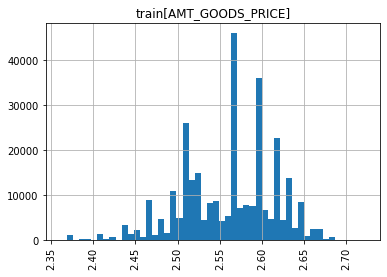

##################################################


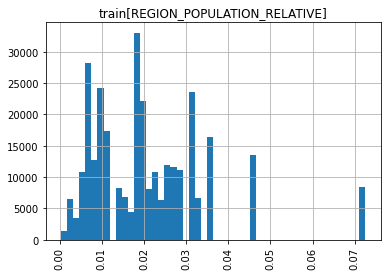

##################################################


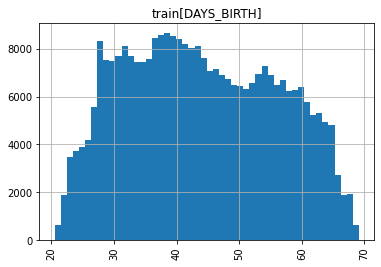

##################################################


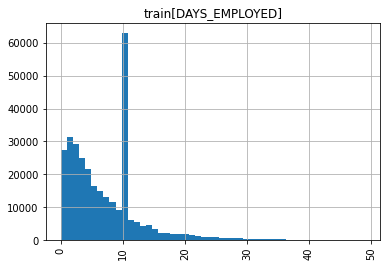

##################################################


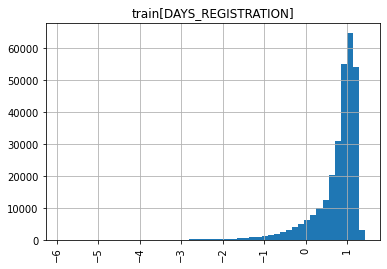

##################################################


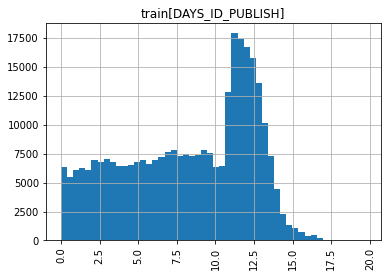

##################################################


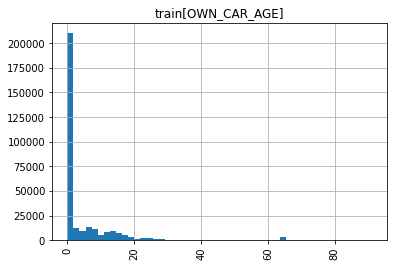

##################################################


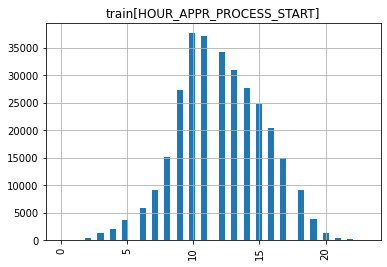

##################################################


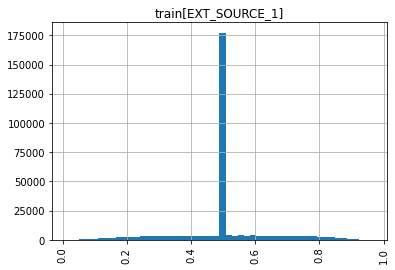

##################################################


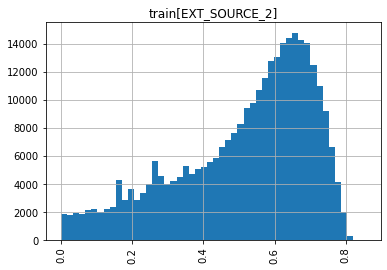

##################################################


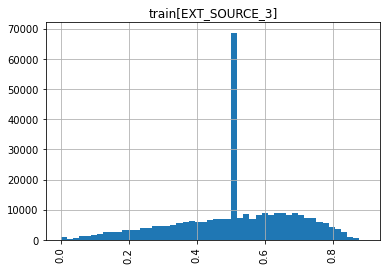

##################################################


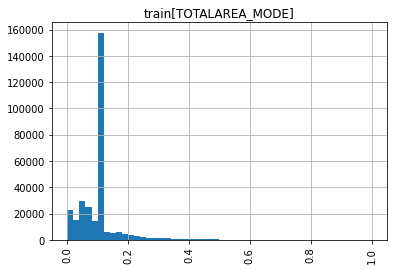

##################################################


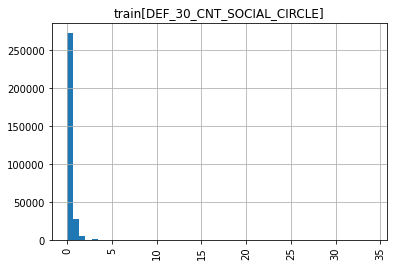

##################################################


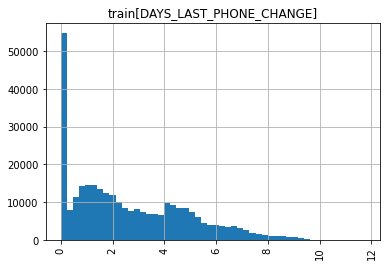

##################################################


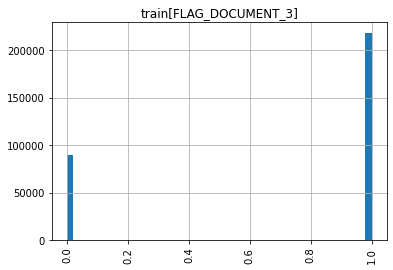

##################################################


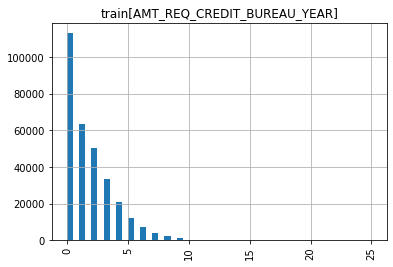

##################################################


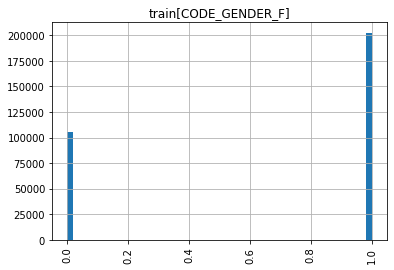

##################################################


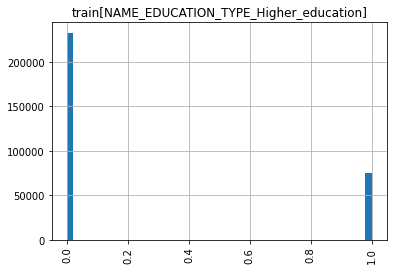

##################################################


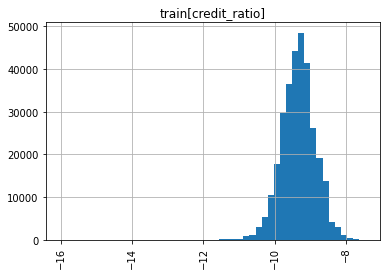

##################################################


In [77]:
# 数値データの分布
for col in train_ver4.columns:
    plt.title('train[{}]'.format(col))
    train_ver4[col].hist(bins=50)
    plt.xticks(rotation=90)
    plt.show()
    
    print('#'*50)

auc:0.73144→0.73276<br>
対数とるとちょっと良くなった？<br>

In [84]:
# AMT系列のデータで比率の特徴量を追加
train_ver5 = feature_engineer(train_ver2)
test_ver5 = feature_engineer(test_ver2)

In [85]:
# ここで再度LGB AMT系列のデータで比率の特徴量を追加
import lightgbm as lgbm
# lgbm = lgbm.LGBMRegressor()
params = {"objective":"binary", 
                  "metric":"binary_logloss", 
                  "verbosity": -1}

X_train, X_test, y_train, y_test = train_test_split(train_ver5, train_y, test_size=0.2)


    #データ読み込み
train_data2=lgbm.Dataset(X_train,label=y_train)

    #パラメータ設定
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

    #学習
num_round=50
start=datetime.now()
lgbm=lgbm.train(param,train_data2,num_round)
stop=datetime.now()

execution_time_lgbm = stop-start
execution_time_lgbm

[LightGBM] [Info] Number of positive: 19809, number of negative: 226199
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080522 -> initscore=-2.435279
[LightGBM] [Info] Start training from score -2.435279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

datetime.timedelta(seconds=6, microseconds=198472)

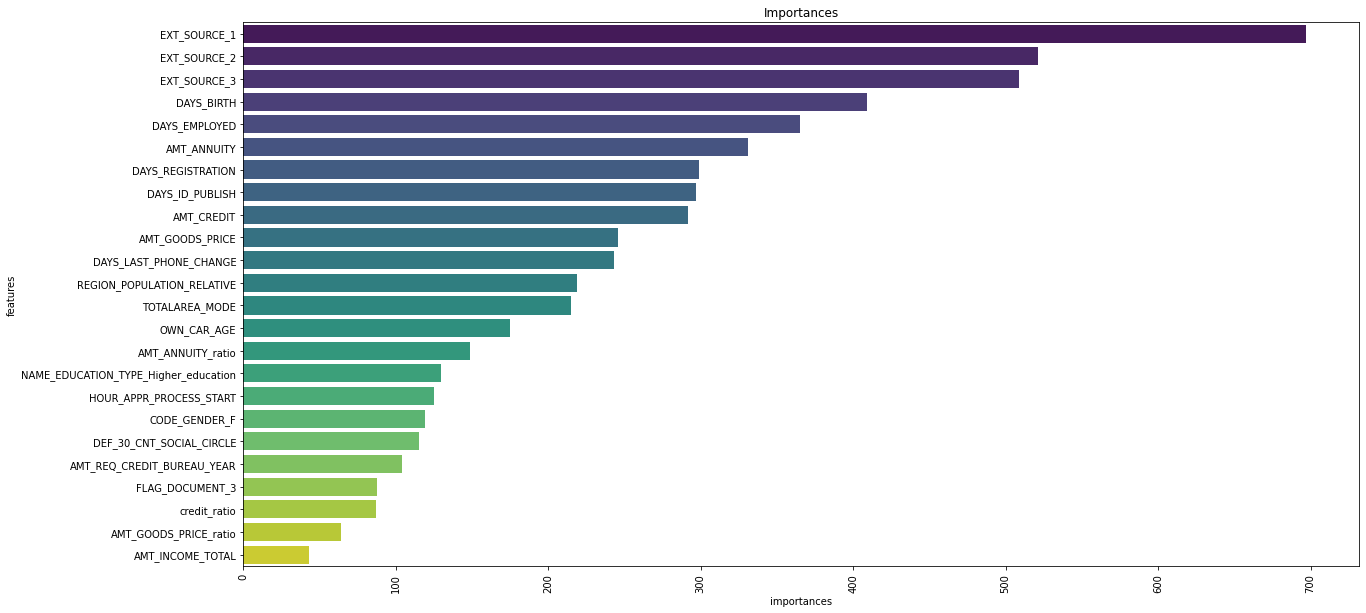

In [86]:
train_feat = list(train_ver5.columns)
# train_feat.remove('SalePrice')
result = pd.DataFrame([lgbm.feature_importance(), train_feat]).T
result.columns = ['importances', 'features']
result.sort_values(by='importances', ascending=False, inplace=True)

plt.figure(figsize=(20,10))
plt.title('Importances')
# plt.rcParams['font.size']=10
sns.barplot(y=result['features'], x=result['importances'], palette='viridis')
plt.xticks(rotation=90)
plt.show() 

auc:0.73276→0.73412<br>
kagglerノートブック参考にドメイン知識の特徴量を作ったら微増<br>
→新規で特徴量を作るとどうやら良さそう<br>
一旦ここまでで提出